## Introduction
In this version:
1) the Diagnostic test is using 19 questions of the experiment. The questions excluded are
        Q2
        Q3
2) The dataset has 87 rows, corresponding to the 87 students that completed the diagnostic.
3) the parameters are set for 3-option questions.



### 1. Justification for Using the 3PL Model
We chose the 3-Parameter Logistic (3PL) model because the test consists of multiple-choice questions with three options, where the potential for guessing or employing answering strategies is a realistic concern. In educational contexts, particularly with younger students or in subjects where background knowledge varies significantly, guessing behavior is often observed. The 3PL model allows us to account for this behavior by including a guessing parameter (c), which reflects the probability of a correct answer purely by chance. This feature makes the 3PL model particularly suited for our data, where the guessing factor is likely to influence the responses.

### 2. Justification for the Bounds on the Difficulty Parameter (b)
The bounds on the difficulty parameter (b) were determined empirically to optimize model fit, as indicated by the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). We adjusted the bounds incrementally, running multiple iterations of the model, and observed changes in AIC and BIC to identify the range that minimized these metrics. This process aligns with standard practices in IRT analysis, where parameter bounds are often fine-tuned based on model selection criteria to ensure an optimal balance between model complexity and data fit.

### 3. Justification for Restricting the Guessing Parameter (c) to 0.25
The guessing parameter (c) was restricted to a minimum of 0.25 to prevent the model from assigning unrealistically low values that do not align with the nature of the test. In a 3-option multiple-choice format, a purely random guess would theoretically yield a 1 in 3 chance, or approximately 0.33. However, we observed that the algorithm often pushed the guessing parameter to much lower levels, likely due to overfitting or noise in the data. Setting the lower bound at 0.25 was a pragmatic choice to reflect that even under minimal knowledge conditions, a student should have at least a 25% chance of guessing correctly. While this exact threshold is not universally standard, it provides a conservative yet reasonable floor that balances between the theoretical guessing rate and observed data tendencies. Additionally, constraining the guessing parameter prevents the model from deviating towards extreme values that could distort the estimation of the other parameters (discrimination and difficulty).

### Additional Justification for the Restriction on the Guessing Parameter
Although the choice of 0.25 as a lower bound is somewhat arbitrary, it is based on the observation that a lower bound close to but slightly below the random guessing rate (0.33) prevents the model from attributing excessively low probabilities to the guessing behavior, which would not be realistic in an educational setting. Furthermore, we acknowledge the trade-off between flexibility in the parameter estimation and the need to maintain plausible values, and this informed our decision to set a minimum at 0.25.


In [1]:
import pandas as pd

# Load the data
file_path = 'DiagnosticResults_19q.csv'
data = pd.read_csv(file_path, index_col=0)

# Drop the first column (subject labels) from the data
# data = data.drop(columns=data.columns[0])


# Example: Define theta as the mean response across items
data.head()

C:\Users\pablo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Q1  Q4  Q5  Q6  Q7  Q8  Q9  Q10  Q11  Q12  Q13  Q14  Q15  Q16  Q17  \
SUBJECT                                                                       
S1        1   1   0   0   0   1   1    1    0    0    1    1    1    1    0   
S2        1   1   0   1   0   1   0    0    0    1    0    0    0    0    0   
S3        1   1   0   1   1   1   0    0    0    0    1    1    0    1    0   
S4        1   1   0   1   0   1   0    0    0    0    1    0    1    1    0   
S7        1   1   0   1   0   1   0    0    0    1    1    0    1    0    0   

         Q18  Q19  Q20  Q21  
SUBJECT                      
S1         0    1    1    1  
S2         0    0    1    1  
S3         1    0    0    0  
S4         0    1    0    0  
S7         0    0    0    1

In [2]:
# Define ability estimates (theta) for each student as initial guess (e.g., average score)
theta = data.mean(axis=1).values

# Assume binary response for simplicity (1 = correct, 0 = incorrect)
responses = data.values  # Convert DataFrame to numpy array for easier manipulation
print(theta)

[0.63157895 0.36842105 0.47368421 0.42105263 0.42105263 0.63157895
 0.42105263 0.42105263 0.36842105 0.52631579 0.47368421 0.36842105
 0.31578947 0.47368421 0.52631579 0.42105263 0.47368421 0.52631579
 0.52631579 0.47368421 0.52631579 0.36842105 0.42105263 0.36842105
 0.31578947 0.26315789 0.42105263 0.47368421 0.36842105 0.42105263
 0.57894737 0.36842105 0.52631579 0.73684211 0.42105263 0.21052632
 0.63157895 0.36842105 0.52631579 0.52631579 0.42105263 0.47368421
 0.47368421 0.73684211 0.36842105 0.52631579 0.52631579 0.47368421
 0.57894737 0.63157895 0.52631579 0.52631579 0.36842105 0.42105263
 0.47368421 0.47368421 0.42105263 0.31578947 0.42105263 0.68421053
 0.57894737 0.47368421 0.47368421 0.42105263 0.47368421 0.42105263
 0.42105263 0.47368421 0.47368421 0.57894737 0.68421053 0.52631579
 0.52631579 0.42105263 0.42105263 0.26315789 0.57894737 0.47368421
 0.36842105 0.26315789 0.63157895 0.36842105 0.47368421 0.52631579
 0.31578947 0.31578947 0.36842105]


In [3]:
import numpy as np
from scipy.optimize import minimize

def three_pl_model(theta, a, b, c):
    return c + (1 - c) / (1 + np.exp(-a * (theta - b)))


In [17]:
def log_likelihood(params, *args):
    theta, responses = args
    a, b, c = params
    prob = three_pl_model(theta, a, b, c)
    
    # Avoid log(0) by clipping probabilities
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    
    # Regularization to penalize large a (high discrimination)
    penalty = 0.1 * (a - 1)**2  # Penalize deviation of a from 1
    
    return -np.sum(responses * np.log(prob) + (1 - responses) * np.log(1 - prob)) + penalty


# Store the estimated parameters
item_parameters = []

for i in range(responses.shape[1]):
    initial_params = [1.0, 0.0, 0.333]  # a, b, c
    """Difficulty bounds were set to +-2.8. This was so because setting higher bounds made a difference only in 4 items (2, 3, 5 and 11). 
    The reasonably minimum bound is 2.8 because the the highest easiness below 2.8 was item 14 (2.755) """
    
    # Adding bounds to ensure valid parameter estimates
    bounds = [(0.01, 5.5),  # a: discrimination should be positive
              (-4, 4),      # b: difficulty can vary widely
              (0.25, 0.35)]  # c: guessing should be between 0 and 1

    # Optimize with bounds
    result = minimize(log_likelihood, initial_params, args=(theta, responses[:, i]), bounds=bounds)
    item_parameters.append(result.x)

# Convert to a DataFrame for easier interpretation
item_params_df = pd.DataFrame(item_parameters, columns=['a', 'b', 'c'])
item_params_df

a         b         c
0   2.702567 -0.100747  0.250000
1   1.682744 -0.583054  0.314158
2   1.752880  4.000000  0.250000
3   3.699774  0.372547  0.250000
4   3.069313  1.099452  0.250000
5   2.422060  0.389341  0.250000
6   1.426124  2.447446  0.250000
7   4.424467  0.676146  0.250000
8   1.751126  4.000000  0.250000
9   0.638974  3.072886  0.262881
10  2.916938  0.505891  0.250000
11  1.635830  4.000000  0.250000
12  2.015684 -0.061726  0.250000
13  2.734598  0.747616  0.250000
14  1.661045  1.986909  0.250000
15  1.333759  4.000000  0.250000
16  2.515168  1.268709  0.250000
17  4.824905  0.639427  0.250000
18  4.496430  0.595030  0.250000

In [18]:
import numpy as np

# Calculate total log-likelihood for all items
total_log_likelihood = 0

for i in range(responses.shape[1]):  # for each item
    a, b, c = item_parameters[i]
    prob = three_pl_model(theta, a, b, c)
    prob = np.clip(prob, 1e-6, 1 - 1e-6)  # Avoid log(0)
    
    # Calculate log-likelihood for this item
    item_log_likelihood = np.sum(responses[:, i] * np.log(prob) + (1 - responses[:, i]) * np.log(1 - prob))
    total_log_likelihood += item_log_likelihood

# Total number of parameters: 3 per item
num_parameters = responses.shape[1] * 3  
num_responses = responses.size  # Total number of responses (students * items)

# Calculate AIC and BIC
aic = 2 * num_parameters - 2 * total_log_likelihood
bic = np.log(num_responses) * num_parameters - 2 * total_log_likelihood

print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

AIC: 1993.74
BIC: 2302.13


In [19]:
theta


array([0.63157895, 0.36842105, 0.47368421, 0.42105263, 0.42105263,
       0.63157895, 0.42105263, 0.42105263, 0.36842105, 0.52631579,
       0.47368421, 0.36842105, 0.31578947, 0.47368421, 0.52631579,
       0.42105263, 0.47368421, 0.52631579, 0.52631579, 0.47368421,
       0.52631579, 0.36842105, 0.42105263, 0.36842105, 0.31578947,
       0.26315789, 0.42105263, 0.47368421, 0.36842105, 0.42105263,
       0.57894737, 0.36842105, 0.52631579, 0.73684211, 0.42105263,
       0.21052632, 0.63157895, 0.36842105, 0.52631579, 0.52631579,
       0.42105263, 0.47368421, 0.47368421, 0.73684211, 0.36842105,
       0.52631579, 0.52631579, 0.47368421, 0.57894737, 0.63157895,
       0.52631579, 0.52631579, 0.36842105, 0.42105263, 0.47368421,
       0.47368421, 0.42105263, 0.31578947, 0.42105263, 0.68421053,
       0.57894737, 0.47368421, 0.47368421, 0.42105263, 0.47368421,
       0.42105263, 0.42105263, 0.47368421, 0.47368421, 0.57894737,
       0.68421053, 0.52631579, 0.52631579, 0.42105263, 0.42105

In [20]:
item_parameters

[array([ 2.70256677, -0.10074652,  0.25      ]),
 array([ 1.68274368, -0.58305364,  0.31415771]),
 array([1.75287963, 4.        , 0.25      ]),
 array([3.69977353, 0.37254653, 0.25      ]),
 array([3.06931345, 1.09945235, 0.25      ]),
 array([2.4220602 , 0.38934054, 0.25      ]),
 array([1.42612447, 2.44744617, 0.25      ]),
 array([4.42446728, 0.67614604, 0.25      ]),
 array([1.75112645, 4.        , 0.25      ]),
 array([0.63897433, 3.07288581, 0.2628811 ]),
 array([2.9169381 , 0.50589094, 0.25      ]),
 array([1.63582967, 4.        , 0.25      ]),
 array([ 2.01568355, -0.06172608,  0.25      ]),
 array([2.73459799, 0.74761568, 0.25      ]),
 array([1.66104478, 1.98690944, 0.25      ]),
 array([1.33375913, 4.        , 0.25      ]),
 array([2.51516819, 1.26870937, 0.25      ]),
 array([4.82490469, 0.63942729, 0.25      ]),
 array([4.49642974, 0.5950301 , 0.25      ])]

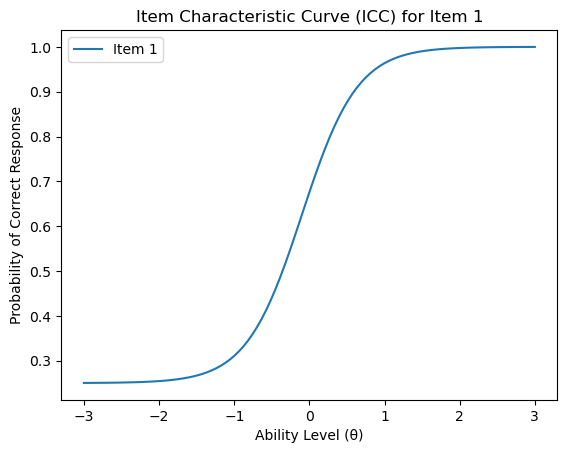

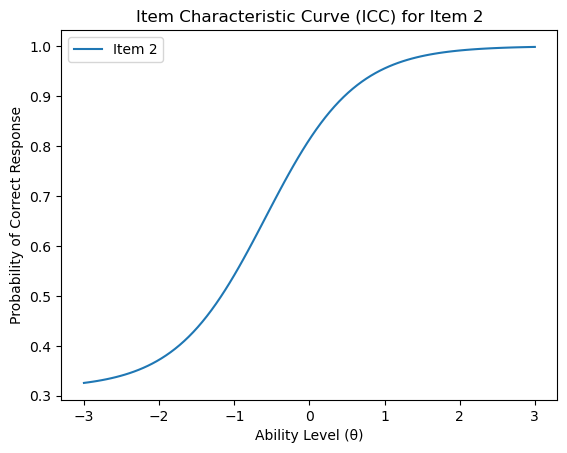

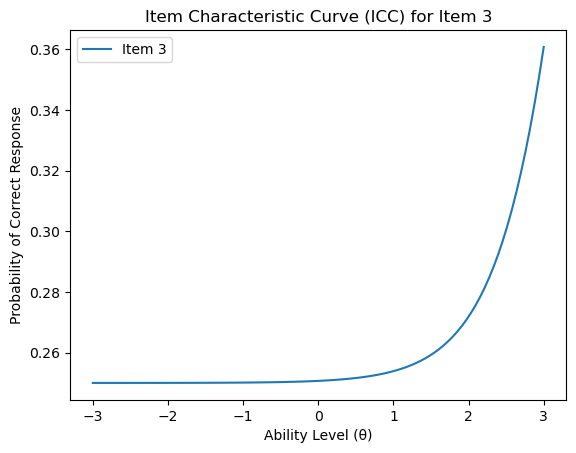

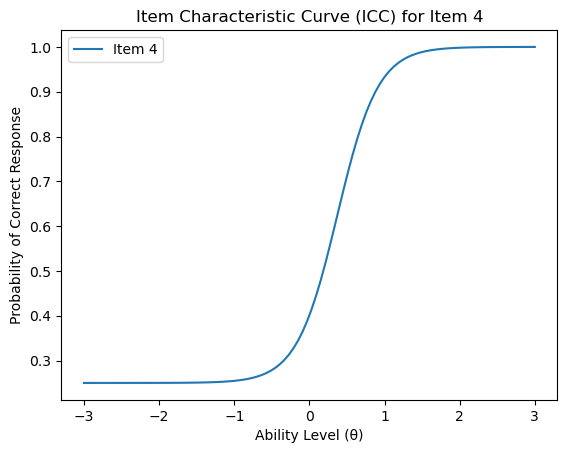

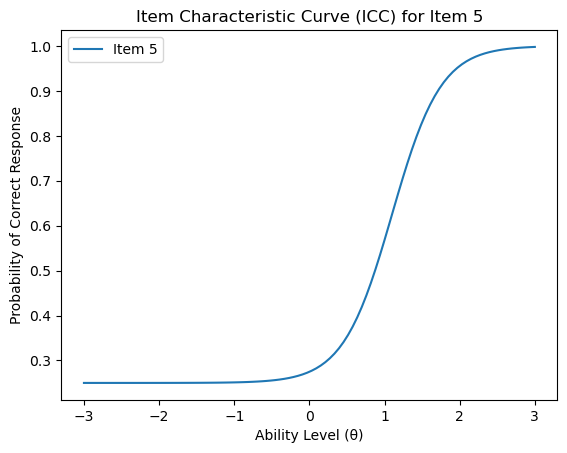

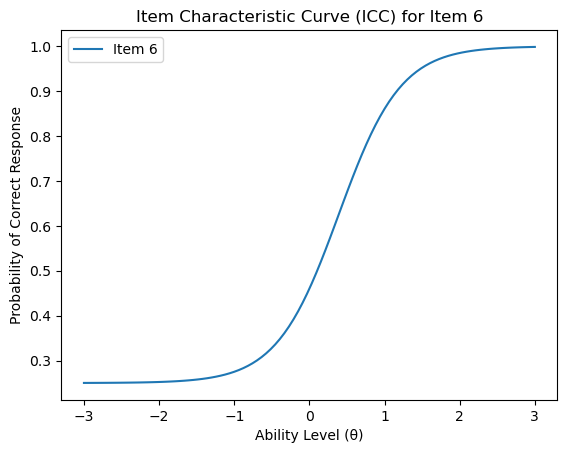

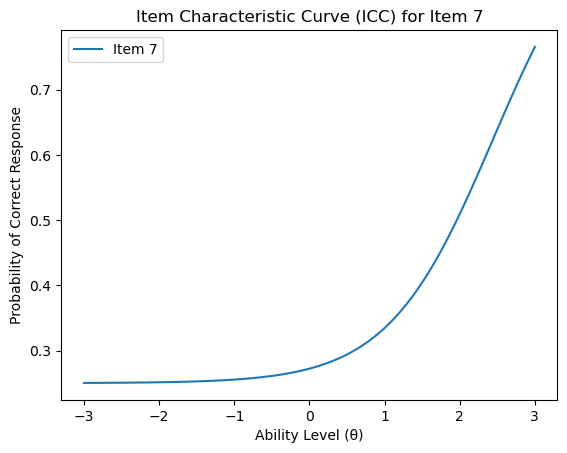

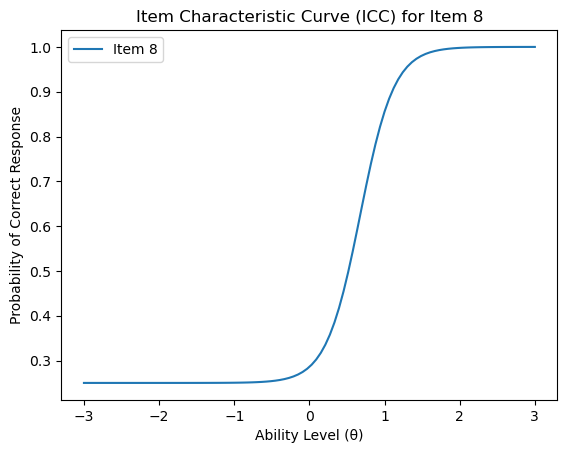

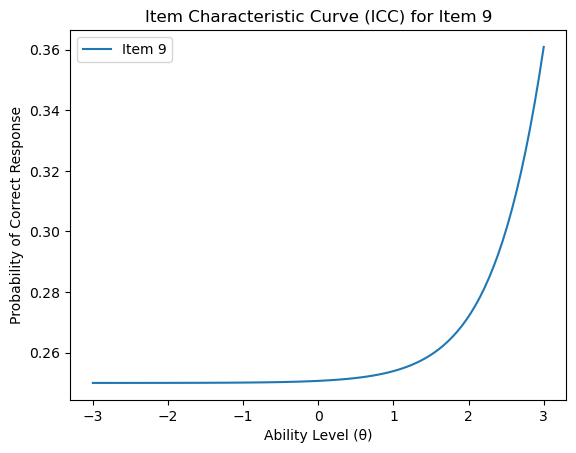

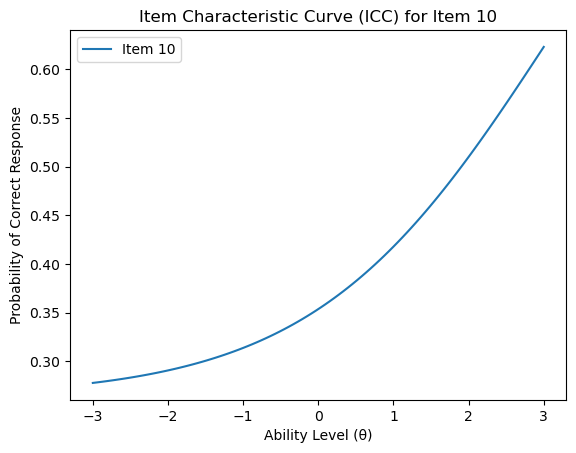

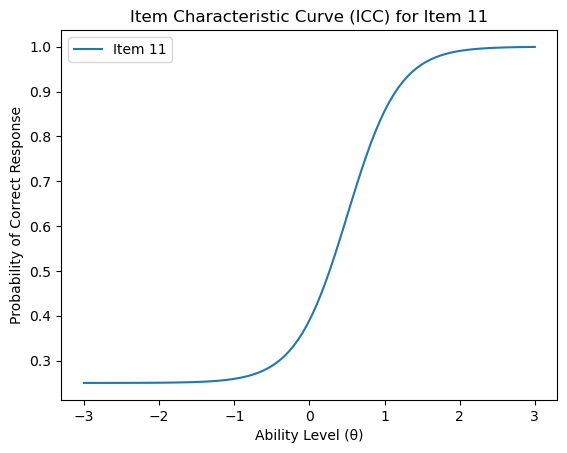

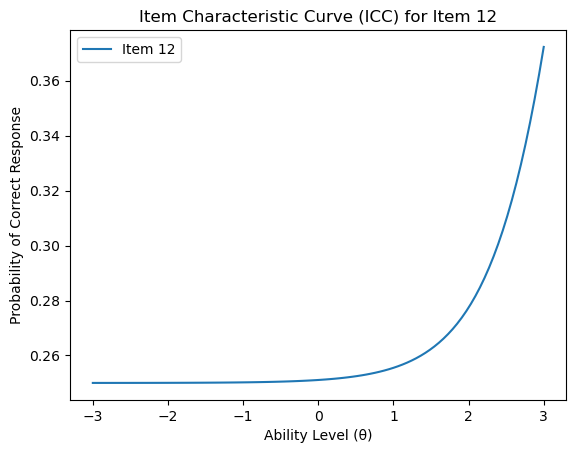

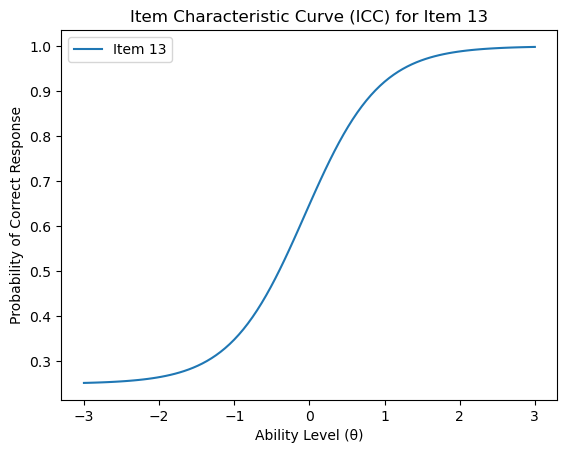

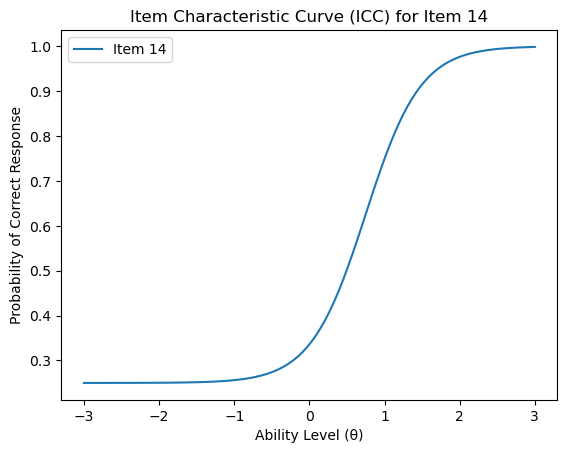

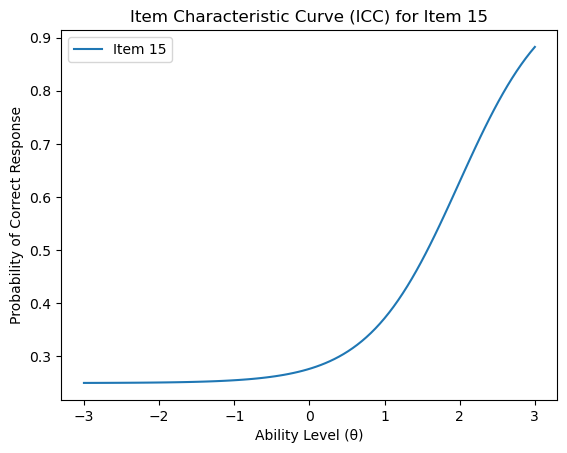

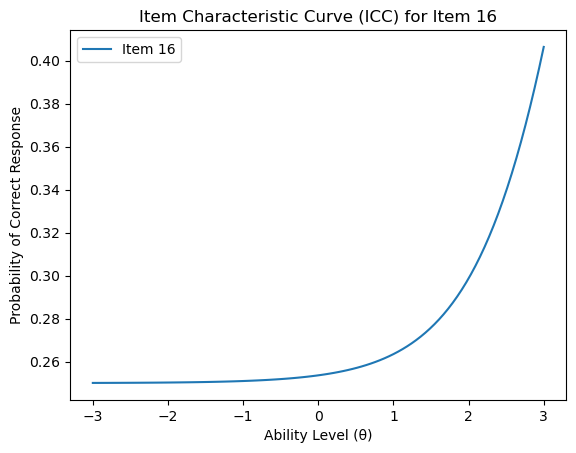

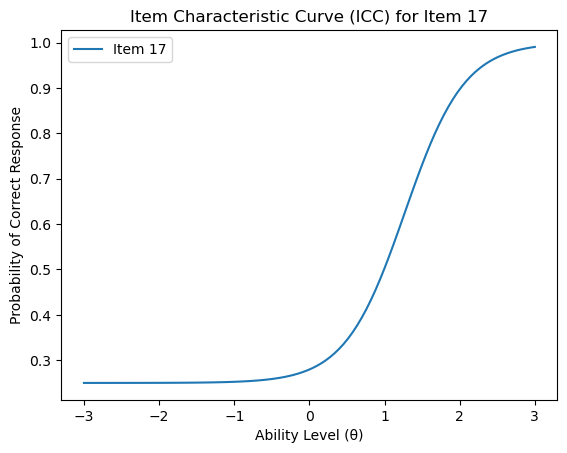

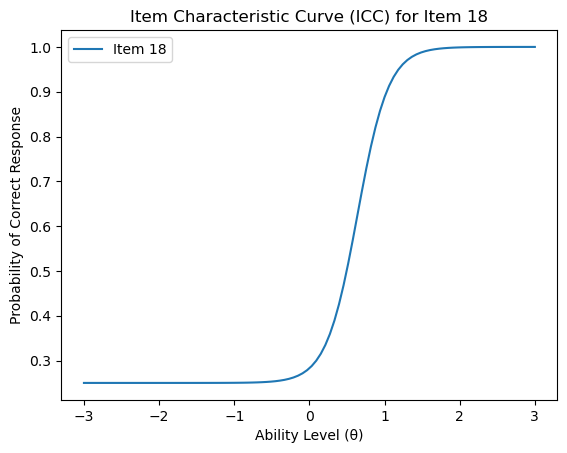

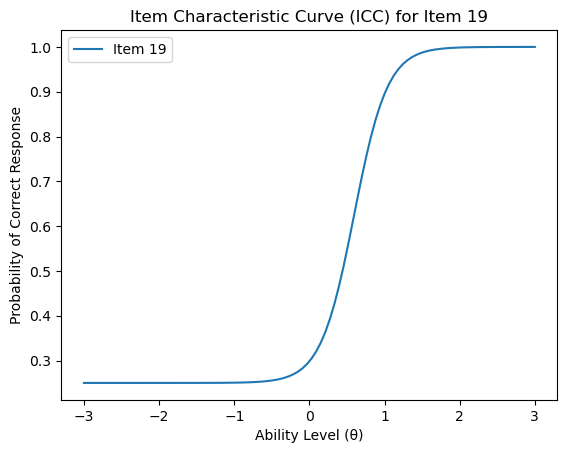

In [21]:
import matplotlib.pyplot as plt

theta_plot = np.linspace(-3, 3, 100)

# Use this theta_plot in the plotting code
for i, params in enumerate(item_parameters):
    a, b, c = params
    predicted_probabilities = three_pl_model(theta_plot, a, b, c)
    
    plt.plot(theta_plot, predicted_probabilities, label=f'Item {i+1}')
    plt.xlabel('Ability Level (θ)')
    plt.ylabel('Probability of Correct Response')
    plt.title(f'Item Characteristic Curve (ICC) for Item {i+1}')
    plt.legend()
    plt.show()


In [22]:
import numpy as np

# Function to compute the probability of a correct response given student's ability (theta)
def probability_correct(theta, a, b, c):
    """Calculate the probability of a correct response given ability (theta), discrimination (a), difficulty (b), and guessing (c)."""
    # Ensure stability by clamping the exponent within reasonable bounds
    exponent = np.clip(-a * (theta - b), -10, 10)
    return c + (1 - c) / (1 + np.exp(exponent))

# Function to estimate the ability (theta) using Maximum Likelihood Estimation (MLE)
def estimate_ability(response_vector, item_parameters, max_iterations=100, learning_rate=0.005, tolerance=1e-6):
    """Estimate the ability of a student using their response pattern and item parameters."""
    print("--------------- estimating ability----------------")
    
    print(response_vector)
    print(item_parameters)
    
    theta = 0  # Start with an initial guess of ability
    i=0
    for _ in range(max_iterations):
        gradient = 0
        hessian = 0
        
        # Calculate gradient and hessian for each item response
        for response, (a, b, c) in zip(response_vector, item_parameters):
            p_correct = probability_correct(theta, a, b, c)
            gradient += (response - p_correct) * (a)
            hessian += a * a * p_correct * (1 - p_correct)
            print(response, a, b, c, p_correct, gradient, hessian)
        
        # Update theta using gradient descent
        if abs(hessian) < tolerance:  # Prevent division by zero
            break
        theta_update = gradient / hessian
        # Clamp theta within a reasonable range to avoid divergence
        theta = np.clip(theta + learning_rate * theta_update, -5, 5)
        
        # Check for convergence
        if abs(theta_update) < tolerance:
            break
    print("theta:", theta)
    return theta

# Estimating abilities for each student using the updated approach
student_abilities = [estimate_ability(student_responses, item_parameters) for student_responses in responses]
print("Estimated Abilities:", student_abilities)

# Plotting the distribution of estimated abilities
import matplotlib.pyplot as plt

plt.hist(student_abilities, bins=20, color='blue', alpha=0.7)
plt.xlabel('Estimated Ability (Theta)')
plt.ylabel('Number of Students')
plt.title('Distribution of Estimated Abilities')
plt.show()


--------------- estimating ability----------------
[1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1]
[array([ 2.70256677, -0.10074652,  0.25      ]), array([ 1.68274368, -0.58305364,  0.31415771]), array([1.75287963, 4.        , 0.25      ]), array([3.69977353, 0.37254653, 0.25      ]), array([3.06931345, 1.09945235, 0.25      ]), array([2.4220602 , 0.38934054, 0.25      ]), array([1.42612447, 2.44744617, 0.25      ]), array([4.42446728, 0.67614604, 0.25      ]), array([1.75112645, 4.        , 0.25      ]), array([0.63897433, 3.07288581, 0.2628811 ]), array([2.9169381 , 0.50589094, 0.25      ]), array([1.63582967, 4.        , 0.25      ]), array([ 2.01568355, -0.06172608,  0.25      ]), array([2.73459799, 0.74761568, 0.25      ]), array([1.66104478, 1.98690944, 0.25      ]), array([1.33375913, 4.        , 0.25      ]), array([2.51516819, 1.26870937, 0.25      ]), array([4.82490469, 0.63942729, 0.25      ]), array([4.49642974, 0.5950301 , 0.25      ])]
1 2.702566766952071 -0.10074652182820729 0.2

0 1.4261244747075537 2.4474461652757107 0.25 0.2725416277688956 2.9918600744993094 9.633617067375928
0 4.42446728380394 0.6761460410732042 0.25 0.2876076932762861 1.719349245028063 13.644515789536072
0 1.751126449570205 4.0 0.25 0.25069384730922767 1.28035261826036 14.220536355627674
1 0.6389743287850249 3.0728858112526725 0.262881096771372 0.35419054205069717 1.6930082831765365 14.313928034349415
1 2.9169380963934324 0.5058909360677194 0.25 0.39335966965311153 3.4625405735740724 16.344299658248765
0 1.6358296694628605 4.0 0.25 0.2510983801140008 3.0517863934295266 16.847504536478887
1 2.015683550921877 -0.06172607616879489 0.25 0.6525641939058311 3.7521070327748256 17.76868033168529
0 2.7345979884756204 0.7476156822147106 0.25 0.3383506125856571 2.826854128198594 19.442782125943925
0 1.661044777730816 1.986909442642029 0.25 0.27715817975044443 2.3664819811187394 19.995538362856724
0 1.333759125016979 4.0 0.25 0.25365201116956054 2.0281712966424292 20.332309206136912
0 2.51516819227413

0 1.4261244747075537 2.4474461652757107 0.25 0.27274752664388996 -3.16024985516041 9.633240701679146
1 4.42446728380394 0.6761460410732042 0.25 0.2886604664742478 -0.012951361399363037 13.652872110859763
0 1.751126449570205 4.0 0.25 0.2507018738219834 -0.45196204360585035 14.228904949023997
1 0.6389743287850249 3.0728858112526725 0.262881096771372 0.35452713257051716 -0.03952145139115115 14.322336657491672
0 2.9169380963934324 0.5058909360677194 0.25 0.395596538619238 -1.1934520656909822 16.356724964319138
0 1.6358296694628605 4.0 0.25 0.2511102387454121 -1.6042256445366296 16.859945638948627
1 2.015683550921877 -0.06172607616879489 0.25 0.6550342271536724 -0.9088838105792344 17.778034469873166
1 2.7345979884756204 0.7476156822147106 0.25 0.33976153185092683 0.8966029763354461 19.455532467865865
0 1.661044777730816 1.986909442642029 0.25 0.2774454658588609 0.4357536341654918 20.00864174481947
0 1.333759125016979 4.0 0.25 0.25368401678949215 0.09740026190154616 20.34544063803439
0 2.515

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1.5904338937336713
1 1.6827436783653407 -0.5830536404079775 0.31415770944458393 0.8147562262706338 1.177683865417032 2.017807052839864
0 1.7528796337441472 4.0 0.25 0.25068467240750975 0.7382638086620849 2.5949675347057872
1 3.699773530195983 0.37254652814901995 0.25 0.4044333114114561 2.9417256785684534 5.892033223650245
0 3.069313450381809 1.0994523547113193 0.25 0.27540054352822335 2.0964350860748167 7.771978822913929
1 2.422060200973162 0.38934053582618466 0.25 0.46306315487207356 3.396928449095258 9.230569051855266
0 1.4261244747075537 2.4474461652757107 0.25 0.27242928463178373 3.0084103786548004 9.633697889917778
0 4.42446728380394 0.6761460410732042 0.25 0.28704095369302135 1.7384070699281458 13.639877575524967
0 1.751126449570205 4.0 0.25 0.2506894769490135 1.299418096213808 14.215891459423055
1 0.6389743287850249 3.0728858112526725 0.262881096771372 0.3540060843306652 1.7121916248778313 14.309261161875627
1 2.9169380963934324 0.5058909360677194 0.25 0.39214203420439936 3.4852

1 1.6827436783653407 -0.5830536404079775 0.31415770944458393 0.8297296639131473 1.0633020202120296 1.8959609220548321
0 1.7528796337441472 4.0 0.25 0.25077071968953796 0.623731132928876 2.4732532130134173
1 3.699773530195983 0.37254652814901995 0.25 0.43735594186713844 2.7053867261308873 5.841617467017419
1 3.069313450381809 1.0994523547113193 0.25 0.2810154290257566 4.912175740439126 7.745026917116981
1 2.422060200973162 0.38934053582618466 0.25 0.48889442352776485 6.150104215707972 9.210897298835592
0 1.4261244747075537 2.4474461652757107 0.25 0.2746248202405046 5.758455038200826 9.616048698135591
0 4.42446728380394 0.6761460410732042 0.25 0.29910970748713955 4.435053923155811 13.720003123699527
0 1.751126449570205 4.0 0.25 0.25077603553817934 3.995913374406548 14.296149332137333
0 0.6389743287850249 3.0728858112526725 0.262881096771372 0.35751218910950794 3.7674722633378352 14.38993199652306
0 2.9169380963934324 0.5058909360677194 0.25 0.41625751446486736 2.5532748614852236 16.45739

1 4.8249046885407525 0.6394272917588089 0.25 0.2911954473247504 9.852867201639175 26.49587476257103
0 4.4964297383142 0.5950300974141641 0.25 0.3094736301869187 8.461340767642662 30.81642978553221
0 2.702566766952071 -0.10074652182820729 0.25 0.7008829030392743 -1.8941828412788335 1.5312269611758706
0 1.6827436783653407 -0.5830536404079775 0.31415770944458393 0.8244573790305663 -3.281533283924176 1.9410408975064497
1 1.7528796337441472 4.0 0.25 0.2507387021891864 -1.968168414638893 2.5182841486789176
1 3.699773530195983 0.37254652814901995 0.25 0.42504036699638414 0.15905201647908163 5.863451230055546
1 3.069313450381809 1.0994523547113193 0.25 0.2788780856658599 2.3724012075099363 7.7579990310413045
1 2.422060200973162 0.38934053582618466 0.25 0.47944352402512047 3.633220330327534 9.222113988581164
0 1.4261244747075537 2.4474461652757107 0.25 0.27381499455635966 3.2427260650487937 9.626521646312536
0 4.42446728380394 0.6761460410732042 0.25 0.29441289479574384 1.9401058440950136 13.69

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [23]:
print("Estimated Abilities:", student_abilities)

Estimated Abilities: [0.24105100491189135, 0.04669179098927243, 0.07253813616724843, 0.05001980230505259, 0.04830638615290518, 0.2508335963052147, 0.021808190105242757, 0.02566954345735561, 0.02986109936096366, 0.17727992629238692, 0.0993208299964081, 0.024985663837421193, -0.02467863245237714, 0.08798833694155178, 0.19895467376929288, 0.05831074997107696, 0.13142786495672404, 0.19491094753608967, 0.16362514076667056, 0.040066672979585105, 0.2143277201450998, -0.026013950370711972, 0.01771178365983483, -0.03171416125021586, -0.017289127314818985, -0.1088846978452745, -0.0461208650481795, 0.17503373018645682, 0.07976940681658709, 0.02769092448067628, 0.2054137226007779, 0.049570780970000956, 0.09084064954849692, 0.2682969446913765, -0.027185887397098263, -0.1001563841653598, 0.2508335963052147, -0.009244746375857569, 0.12109658495206302, 0.13151426596415294, 0.01253361891050817, 0.10706670609735956, 0.1578718354108138, 0.2680538793974344, -0.030113572406991338, 0.14848397344287464, 0.12

In [24]:
import numpy as np
import pandas as pd

# Your ability dataset
abilities = np.array([
    0.2775594797, 0.0892625802, 0.05547972409, 0.1409317286, 0.1367164543,
    0.1718606492, 0.1258888579, 0.1146645792, 0.03442929903, 0.1868447573,
    0.1659471333, 0.1080680106, 0.0605544079, 0.1852170077, 0.2433979962,
    0.1065560475, 0.1835040602, 0.2052375357, 0.1990506623, 0.007166755034,
    0.2636409509, 0.0102669741, 0.1200834965, 0.05274388131, 0.08199193848,
    -0.04945664536, 0.0216964552, 0.2273037199, 0.09716344505, 0.06307965595,
    0.2132295577, 0.1197763823, 0.149694307, 0.1777136009, 0.06680435618,
    -0.003245667415, 0.1718606492, -0.03417508778, 0.1715062631, 0.1637596542,
    0.0843143855, 0.0598385218, 0.2264692415, 0.2115908429, 0.03714473619,
    0.1931260746, 0.2189983307, 0.1517205839, 0.2577032775, 0.2276322267,
    0.1490166795, 0.2166832523, -0.1021812715, -0.03548459085, 0.06895099716,
    0.1441080942, 0.09272903425, -0.03073552239, 0.1661511562, 0.2850473331,
    0.1100001402, 0.1577511204, 0.1050628919, 0.1540737272, 0.1736988683,
    0.02015412104, 0.07252659245, 0.07221606131, 0.1548889722, 0.2332243336,
    0.2287066716, 0.08244580827, 0.1388567672, 0.09117830909, 0.05771035373,
    0.00963459402, 0.2288431471, 0.1402701622, 0.03664039617, -0.02676511375,
    0.1899569995, 0.1266979899, 0.2138452462, 0.2292903077, 0.06147475966,
    0.02937078258, 0.1136084618
])

# Convert to DataFrame for easier handling
# df = pd.DataFrame({'ability': abilities})

df = pd.DataFrame({'ability': student_abilities})
# Calculate percentiles
lower_cutoff = np.percentile(abilities, 25)  # 25th percentile
upper_cutoff = np.percentile(abilities, 75)  # 75th percentile

# Assign categories
df['category'] = pd.cut(df['ability'], 
                        bins=[-np.inf, lower_cutoff, upper_cutoff, np.inf], 
                        labels=['Low Ability', 'Medium Ability', 'High Ability'])

print(df.head())  # Display the first few rows

    ability        category
0  0.241051    High Ability
1  0.046692     Low Ability
2  0.072538  Medium Ability
3  0.050020     Low Ability
4  0.048306     Low Ability


In [26]:
print(lower_cutoff, upper_cutoff)


0.062277207805 0.1860308825
